# Table of Contents
* [1. Intraday asymetry](#1.-Intraday-asymetry)
	* [1.1 Setup](#1.1-Setup)
		* [1.1.1 Initiate R](#1.1.1-Initiate-R)
		* [1.1.2 Load data](#1.1.2-Load-data)
		* [1.1.3 Check data](#1.1.3-Check-data)
			* [1.1.3.1 DK1](#1.1.3.1-DK1)
			* [1.1.3.2 SE2](#1.1.3.2-SE2)
			* [1.1.3.3 SE4](#1.1.3.3-SE4)
	* [1.2 Descriptive statistics](#1.2-Descriptive-statistics)
	* [1.3 Analysis per bidding zone](#1.3-Analysis-per-bidding-zone)
		* [1.3.1 DK1](#1.3.1-DK1)
			* [1.3.1.1 Per hour](#1.3.1.1-Per-hour)
				* [1.3.1.1.1 Automatic model selection](#1.3.1.1.1-Automatic-model-selection)
				* [1.3.1.1.2 Manual model selection](#1.3.1.1.2-Manual-model-selection)
		* [1.3.2 SE2](#1.3.2-SE2)
			* [1.3.2.1 Per hour](#1.3.2.1-Per-hour)
				* [1.3.2.1.1 Manual model selection](#1.3.2.1.1-Manual-model-selection)
		* [1.3.3 SE4](#1.3.3-SE4)
			* [1.3.3.1 Per hour](#1.3.3.1-Per-hour)
				* [1.3.3.1.1 Manual model selection](#1.3.3.1.1-Manual-model-selection)
	* [1.4 Conclusion](#1.4-Conclusion)


# 1. Intraday asymetry

Analysing whether underestimating, as apposed to overestimating, consumption or wind production results in a different sized price premium (i.e. difference between day-ahead price and the average intraday price).

## 1.1 Setup

### 1.1.1 Initiate R

In [1]:
library(gridExtra)
#library(MASS)
library(tidyverse)
library(lubridate)
#library(forcats)
library(forecast)
#library(tseries)
Sys.setlocale("LC_TIME", "C") # turn off locale-specific sorting

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.3.4     v dplyr   0.7.4
v tidyr   0.7.2     v stringr 1.2.0
v readr   1.1.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::combine() masks gridExtra::combine()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



[1] "C"

In [2]:
# Functions
'%nin%' = Negate('%in%')
# Weekday, where week starts on Mondays (instead of Sundays).
source("functions/wday1.R")
# Creates dummy variables (with specific prefix) from a categorical variable/factors.
source("functions/d.R")
# Returns a well-formated dataframe with parameter estimates and standard errors, from a list of fits from SARIMA models.
source("functions/wellformated.R")
# Returns only the p-value and ignore (some) warnings.
#source("functions/kpss.test.p.value.R")
# Returns the index of the n smallest or largest value; which.max.n(x,n) or which.min.n(x,n)
source("functions/which.max.n.R")
# Extend R's regrex function such that non-matched patterns return empty string
source("functions/grepsub.R")
# Quick summary statistics of variables
source("functions/describe.R")

### 1.1.2 Load data

In [3]:
df = read.csv(gzfile("../Data/complete.csv.gz"))

In [4]:
# Scale variables (thereby reducing computational time); from MWh to GWh
df = df %>% mutate(
                Cons = Cons/1000, 
                Cons.Est = Cons.Est/1000,
                Prod = Prod/1000,
                Prod.Est = Prod.Est/1000,
                Wind = Wind/1000,
                Wind.Est = Wind.Est/1000,
                DA.volume = DA.volume/1000,
                DA.volume.buy = DA.volume.buy/1000,
                DA.volume.sell = DA.volume.sell/1000,
                ID.vol = ID.vol/1000)

In [5]:
# Convert to datetime format
df$dt = ymd_hms(df$dt)
# Set intraday price equal to day-ahead price if missing (ie. spread between prices becomes zero).
df[which(is.na(df$ID.avg)),"ID.avg"] = df[which(is.na(df$ID.avg)),"DA.price"]
# Price spread between intraday market and day-ahead market
df$Spread = df$ID.avg - df$DA.price
# Forecast errrors
df$FE.Cons = df$Cons.Est - df$Cons
df$FE.Prod = df$Prod.Est - df$Prod
df$FE.Wind = df$Wind.Est - df$Wind
# Dummy for positive forecast errors
df$FE.Cons.Pos = df$FE.Cons > 0
df$FE.Prod.Pos = df$FE.Prod > 0
df$FE.Wind.Pos = df$FE.Wind > 0
# Initial mark no observation as outlier
df$outlier = 0

Splitting data by bidding zones, and limiting to time period with complete data coverage (see the last tables in the [merge script](../Data/merge.ipynb))

In [6]:
# Split in bidding zones
df.DK1 = df %>% subset(Area == "DK1" & dt >= ymd_hms("2013-01-01 00:00:00") & dt < ymd_hms("2017-01-01 00:00:00"))
#df.DK2 = df %>% subset(Area == "DK2" & dt >= ymd_hms("2013-01-01 00:00:00"))
#df.SE1 = df %>% subset(Area == "SE1" & dt >= ymd_hms("2015-01-27 00:00:00"))
df.SE2 = df %>% subset(Area == "SE2" & dt >= ymd_hms("2015-01-27 00:00:00") & dt < ymd_hms("2017-01-01 00:00:00"))
#df.SE3 = df %>% subset(Area == "SE3" & dt >= ymd_hms("2015-01-27 00:00:00"))
df.SE4 = df %>% subset(Area == "SE4" & dt >= ymd_hms("2015-01-27 00:00:00") & dt < ymd_hms("2017-01-01 00:00:00"))

### 1.1.3 Check data

#### 1.1.3.1 DK1

In [7]:
# Any gaps in datatime?
#idx_time = seq(min(df.DK1$dt), max(df.DK1$dt), by = "hour")
#any(idx_time %nin% df.DK1$dt) # False
# Any duplicates in datetime?
#any(duplicated(df.DK1$dt)) # False
#df.DK1[duplicated(df.DK1$dt) | duplicated(df.DK1$dt, fromLast=T),]
# Missing values
missingvalues = colSums(is.na(df.DK1))
missingvalues[missingvalues>0] %>% t() %>% as.data.frame()
# Display rows with missing values
#df.DK1 %>% subset(is.na(Spread)) # Day-light savings

ID.high ID.low ID.last ID.avg ID.vol DA.price DA.volume.buy DA.volume.sell
1 6739    6739   6739    4      6739   4        4             4             
  DA.volume Cons.Est ... Prod.Est Wind.Est Wind Spread FE.Cons FE.Prod FE.Wind
1 35064     4        ... 4        4        4    4      4       4       4      
  FE.Cons.Pos FE.Prod.Pos FE.Wind.Pos
1 4           4           4

In [8]:
# Set these missing values / DST equal to value in previous hour
df.DK1 = df.DK1 %>% 
            arrange(dt) %>% 
            fill(ID.avg, DA.price, DA.volume.buy, DA.volume.sell, Cons.Est, Cons, Prod, Prod.Est, Wind.Est, Wind, Spread, FE.Cons, FE.Prod, FE.Wind, FE.Cons.Pos, FE.Prod.Pos, FE.Wind.Pos)

In [9]:
## Outlier detection (visual)
#pp.DK1.visual.comparison = list()
#pp.DK1.visual.comparison[[1]] = df.DK1 %>% ggplot(aes(x=Cons.Est, y=Cons)) + geom_abline(slope=1) + geom_point()
#pp.DK1.visual.comparison[[2]] = df.DK1 %>% ggplot(aes(x=Wind.Est, y=Wind)) + geom_abline(slope=1) + geom_point()
#pp.DK1.visual.comparison[[3]] = df.DK1 %>% ggplot(aes(x=ID.avg, y=DA.price)) + geom_abline(slope=1) + geom_point()
#marrangeGrob(pp.DK1.visual.comparison, nrow = 3, ncol=1, top = NULL)

In [10]:
## From visual inspection above there seems to be some outliers in Spread
#df.DK1[which.min.n(df.DK1$Spread,6),c("dt","ID.avg","DA.price","Spread","outlier")]
#df.DK1[which.max.n(df.DK1$Spread,2),c("dt","ID.high", "ID.low", "ID.last","ID.avg","DA.price","Spread","outlier")]

In [11]:
# Mark these observations as outliers
df.DK1[which(df.DK1$Spread < -1500 | df.DK1$Spread > 150),]$outlier = 1

In [12]:
# Set Spread of outliers equal zero:
df.DK1[which(df.DK1$Spread < -1500 | df.DK1$Spread > 150),]$Spread = 0
## Set Spread of outliers equal to the Spread 24 hours before:
#idx.outliers = which(df.DK1$Spread < -1500 | df.DK1$Spread > 150)
#idx.outliers.dday = which(df.DK1$dt %in% (df.DK1[idx.outliers,]$dt - ddays(1)))
#df.DK1[idx.outliers,]$Spread = df.DK1[idx.outliers.dday,]$Spread

In [13]:
## From visual inspection above there seems to be some outliers in FE.Cons
#df.DK1[which.min.n(df.DK1$FE.Cons,2),c("dt","Cons","Cons.Est","FE.Cons","outlier")]

In [14]:
## From visual inspection above there seems to be no outliers in FE.Wind. 
## However there seems to be a slight underestimation at very high wind production levels.

#### 1.1.3.2 SE2

In [15]:
# Any gaps in datatime?
#idx_time = seq(min(df.SE2$dt), max(df.SE2$dt), by = "hour")
#any(idx_time %nin% df.SE2$dt) # False
# Any duplicates in datetime?
#any(duplicated(df.SE2$dt)) # False
#df.SE2[duplicated(df.SE2$dt) | duplicated(df.SE2$dt, fromLast=T),]
# Missing values
missingvalues = colSums(is.na(df.SE2))
missingvalues[missingvalues>0] %>% t() %>% as.data.frame()
# Display rows with missing values
#df.SE2 %>% subset(is.na(Spread)) # Day-light savings

ID.high ID.low ID.last ID.avg ID.vol DA.price DA.volume.buy DA.volume.sell
1 395     395    395     2      395    2        2             2             
  DA.volume Cons.Est ... Prod.Est Wind.Est Wind Spread FE.Cons FE.Prod FE.Wind
1 16920     26       ... 2        2        2    2      26      2       2      
  FE.Cons.Pos FE.Prod.Pos FE.Wind.Pos
1 26          2           2

In [16]:
# Set these missing values / DST equal to value in previous hour
df.SE2 = df.SE2 %>% 
            arrange(dt) %>% 
            fill(ID.avg, DA.price, DA.volume.buy, DA.volume.sell, Cons.Est, Cons, Prod, Prod.Est, Wind.Est, Wind, Spread, FE.Cons, FE.Prod, FE.Wind, FE.Cons.Pos, FE.Prod.Pos, FE.Wind.Pos)

In [17]:
## Outlier detection (visual)
#pp.SE2.visual.comparison = list()
#pp.SE2.visual.comparison[[1]] = df.SE2 %>% ggplot(aes(x=Cons.Est, y=Cons)) + geom_abline(slope=1) + geom_point()
#pp.SE2.visual.comparison[[2]] = df.SE2 %>% ggplot(aes(x=Wind.Est, y=Wind)) + geom_abline(slope=1) + geom_point()
#pp.SE2.visual.comparison[[3]] = df.SE2 %>% ggplot(aes(x=ID.avg, y=DA.price)) + geom_abline(slope=1) + geom_point()
#marrangeGrob(pp.SE2.visual.comparison, nrow = 3, ncol=1, top = NULL)

In [18]:
## From visual inspection above there might be some outliers in FE.Cons
#df.SE2[which.max.n(df.SE2$FE.Cons,2),c("dt","Cons","Cons.Est","FE.Cons","outlier")]
#df.SE2[which.min.n(df.SE2$FE.Cons,14),c("dt","Cons","Cons.Est","FE.Cons","outlier")]

In [19]:
## From visual inspection above there might be some outliers in Spread
#df.SE2[which.max.n(df.SE2$Spread,10),c("dt","DA.price","ID.avg","Spread","outlier")]
#df.SE2[which.min.n(df.SE2$Spread,10),c("dt","DA.price","ID.avg","Spread","outlier")]

#### 1.1.3.3 SE4

In [20]:
# Any gaps in datatime?
#idx_time = seq(min(df.SE4$dt), max(df.SE4$dt), by = "hour")
#any(idx_time %nin% df.SE4$dt) # False
# Any duplicates in datetime?
#any(duplicated(df.SE4$dt)) # False
#df.SE4[duplicated(df.SE4$dt) | duplicated(df.SE4$dt, fromLast=T),]
# Missing values
missingvalues = colSums(is.na(df.SE4))
missingvalues[missingvalues>0] %>% t() %>% as.data.frame()
# Display rows with missing values
#df.SE4 %>% subset(is.na(Spread)) # Day-light savings

ID.high ID.low ID.last ID.avg ID.vol DA.price DA.volume.buy DA.volume.sell
1 5806    5806   5806    2      5806   2        2             2             
  DA.volume Cons.Est ... Prod.Est Wind.Est Wind Spread FE.Cons FE.Prod FE.Wind
1 16920     26       ... 2        2        2    2      26      2       2      
  FE.Cons.Pos FE.Prod.Pos FE.Wind.Pos
1 26          2           2

In [21]:
# Set these missing values / DST equal to value in previous hour
df.SE4 = df.SE4 %>% 
            arrange(dt) %>% 
            fill(ID.avg, DA.price, DA.volume.buy, DA.volume.sell, Cons.Est, Cons, Prod, Prod.Est, Wind.Est, Wind, Spread, FE.Cons, FE.Prod, FE.Wind, FE.Cons.Pos, FE.Prod.Pos, FE.Wind.Pos)

In [22]:
## Outlier detection (visual)
#pp.SE4.visual.comparison = list()
#pp.SE4.visual.comparison[[1]] = df.SE4 %>% ggplot(aes(x=Cons.Est, y=Cons)) + geom_abline(slope=1) + geom_point()
#pp.SE4.visual.comparison[[2]] = df.SE4 %>% ggplot(aes(x=Wind.Est, y=Wind)) + geom_abline(slope=1) + geom_point()
#pp.SE4.visual.comparison[[3]] = df.SE4 %>% ggplot(aes(x=ID.avg, y=DA.price)) + geom_abline(slope=1) + geom_point()
#marrangeGrob(pp.SE4.visual.comparison, nrow = 3, ncol=1, top = NULL)

In [23]:
## From visual inspection above there seems to be some outliers in Spread
#df.SE4[which.min.n(df.SE4$Spread,2),c("dt","ID.high", "ID.low", "ID.last","ID.avg","DA.price","Spread","outlier")]
#df.SE4[which.max.n(df.SE4$Spread,5),c("dt","ID.high", "ID.low", "ID.last","ID.avg","DA.price","Spread","outlier")]

In [24]:
# Mark these observations as outliers
df.SE4[which(df.SE4$Spread < -130 | df.SE4$Spread > 110),]$outlier = 1

In [25]:
# Set Spread of outliers equal zero:
df.SE4[which(df.SE4$Spread < -130 | df.SE4$Spread > 110),]$Spread = 0
## Set Spread of outliers equal to the Spread 24 hours before:
#idx.outliers = which(df.SE4$Spread < -130 | df.SE4$Spread > 110)
#idx.outliers.dday = which(df.SE4$dt %in% (df.SE4[idx.outliers,]$dt - ddays(1)))
#df.SE4[idx.outliers,]$Spread = df.SE4[idx.outliers.dday,]$Spread

In [26]:
## From visual inspection above there seems to be some outliers in FE.Cons
## However there seems to be a slight underestimation at very high consumption levels.

In [27]:
## From visual inspection above there seems to be no outliers in FE.Wind. 
## However there seems to be a slight underestimation at very high wind production levels.

-----

## 1.2 Descriptive statistics

In [28]:
df %>% select(-dt, -Area, -Country) %>% describe()

var            type  N      mean   median sd     min       max     
1  Cons           <dbl> 862678  3.216  2.196  2.870     0.000   17.677
2  Cons.Est       <dbl> 532415  3.383  1.778  3.503     0.000   18.215
3  DA.price       <dbl> 639065 31.769 30.340 14.059   -62.030 2000.000
4  DA.volume      <dbl>  43195 40.411 39.506  7.938    22.212   65.311
5  DA.volume.buy  <dbl> 644254  2.848  1.982  2.389     0.124   16.353
6  DA.volume.sell <dbl> 644254  2.849  2.071  2.429     0.000   12.353
7  FE.Cons        <dbl> 532205  0.003  0.003  0.206   -12.782   14.462
8  FE.Cons.Pos    <dbl> 532205  0.519  1.000  0.500     0.000    1.000
9  FE.Prod        <dbl> 830285 -0.056  0.000  0.312    -7.881   19.758
10 FE.Prod.Pos    <dbl> 830285  0.394  0.000  0.489     0.000    1.000
11 FE.Wind        <dbl> 352088 -0.001  0.002  0.130   -37.248    7.978
12 FE.Wind.Pos    <dbl> 352088  0.525  1.000  0.499     0.000    1.000
13 Holiday_DE     <dbl> 982510  0.024  0.000  0.154     0.000    1.000
14 Holiday_DK     <dbl> 982510  0.040  0.000  0.195     0.000    1.000
15 Holiday_EE     <dbl> 982510  0.032  0.000  0.176     0.000    1.000
16 Holiday_FI     <int> 982510  0.040  0.000  0.196     0.000    1.000
17 Holiday_LV     <int> 982510  0.036  0.000  0.187     0.000    1.000
18 Holiday_NO     <int> 982510  0.032  0.000  0.176     0.000    1.000
19 Holiday_SE     <int> 982510  0.043  0.000  0.203     0.000    1.000
20 ID.avg         <int> 745404 33.247 31.100 14.977  -150.000  904.435
21 ID.high        <int> 438232 38.430 34.500 20.849  -150.000 1500.000
22 ID.last        <int> 438232 34.399 32.000 17.293  -175.000  850.100
23 ID.low         <dbl> 438232 31.098 29.900 15.202  -175.000  600.000
24 ID.vol         <dbl> 438232  0.143  0.059  0.231     0.000    4.645
25 outlier        <dbl> 982510  0.000  0.000  0.000     0.000    0.000
26 Prod           <dbl> 862678  3.218  2.314  2.749    -0.588   18.585
27 Prod.Est       <lgl> 830563  3.145  2.201  2.776    -0.235   24.107
28 Spread         <lgl> 639065  0.070  0.000  8.235 -1930.832  177.410
29 Wind           <lgl> 352526  0.369  0.138  0.535    -0.002   37.497
30 Wind.Est       <dbl> 377393  0.366  0.147  0.528     0.000    9.063

In [29]:
# Wind production share of consumption in each bidding area.
df %>%
    group_by(Area) %>% 
    summarise(Wind.share.of.Cons = mean(Wind/Cons, na.rm=T)) 

Area Wind.share.of.Cons
1  DK1  0.43875180        
2  DK2  0.18225200        
3  EE          Inf        
4  FI          NaN        
5  LT          Inf        
6  LV   0.01514412        
7  NO1         NaN        
8  NO2         NaN        
9  NO3         NaN        
10 NO4         NaN        
11 NO5         NaN        
12 SE1  0.14635082        
13 SE2  0.31688565        
14 SE3  0.06729609        
15 SE4  0.17238796        
16 SYS         NaN        
17 NA          NaN

In [30]:
# The share of hours for which the intraday market receives bids.
df %>% 
    subset(year(dt) < 2017) %>%
    group_by(Area) %>%  
    summarise(
        DA.price.nonmissing = sum(!is.na(DA.price)),
        ID.last.missing = sum(!is.na(DA.price) & is.na(ID.last)),
        ID.last.nonmissing.share = 1-ID.last.missing/DA.price.nonmissing
    ) %>%
    select(Area, ID.last.nonmissing.share)

Area ID.last.nonmissing.share
1  DK1  0.8079007               
2  DK2  0.7624358               
3  EE   0.5544210               
4  FI   0.5226754               
5  LT   0.4679407               
6  LV   0.4719169               
7  NO1  0.2409013               
8  NO2  0.3847975               
9  NO3  0.3895893               
10 NO4  0.2213634               
11 NO5  0.2727325               
12 SE1  0.8266115               
13 SE2  0.9798631               
14 SE3  0.9844552               
15 SE4  0.6284084               
16 SYS  0.9998289               
17 NA         NaN

Below we focus on three bidding areas: DK1, SE2 and SE4.

* **DK1:** Very larege wind production relative to consumption (44%). Moderate use of inraday market (bids in 81% of all hours).
* **SE2:** Large wind production relative to consumption (32%). High use of intraday market (bids in 98% of all hours).
* **SE4:** Moderate wind production relative to consumption (17%). Low use of intraday market (bids in 63% of all hours).

## 1.3 Analysis per bidding zone

Below we use the following procedure:

1. Setup and structure the data (into 'per hour' time series) and run simple linear regression model, both of which is for later use.
2. Test the stationarity of the independent variables, dependent variables and residual from the simple regression model. And if necessary, differnce the data.
3. Remove insignificant dependent variables.

    4a. **Automatically** select the ARIMA model that "best" fits the data.  
    5a. Check model: roots of the characteristic polynomial, autocorrelation of residuals, correlation of residuals across models/hours etc. And investigate the automatic model selection process.  
    6a. Re-estimate model; with lags/previous hours, manually selected AR and MA lags, etc.  

    4b. **Manually** select the ARIMA model based on ACF and PACF plots.  
    5b. Check model: roots of the characteristic polynomial, autocorrelation of residuals, correlation of residuals across models/hours etc.  
    6b. Re-estimate model; with lags/previous hours, manually selected AR and MA lags, etc.  

### 1.3.1 DK1

#### 1.3.1.1 Per hour

In [185]:
# ACF and PACF per hour
pp.ts.DK1.acf = list()
pp.ts.DK1.pacf = list()
for(hour in 1:24) {
    ts = df.DK1 %>% 
            subset(hour(dt) == hour-1) %>% 
            select(Spread) %>%
            ts(frequency=7)
    pp.ts.DK1.acf[[hour]] = ts %>% ggAcf() + labs(title = sprintf("Hour %i",hour), subtitle = "Time-series")
    pp.ts.DK1.pacf[[hour]] = ts %>% ggPacf() + labs(title = sprintf("Hour %i",hour), subtitle = "Time-series")
}
p.ts.DK1.acf = marrangeGrob(pp.ts.DK1.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1")
ggsave("figures/p.ts.DK1.acf.pdf", p.ts.DK1.acf, width=420, height=297, units="mm")
p.ts.DK1.pacf = marrangeGrob(pp.ts.DK1.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1")
ggsave("figures/p.ts.DK1.pacf.pdf", p.ts.DK1.pacf, width=420, height=297, units="mm")

In [186]:
# Step 1: Subset and setup.
df.DK1.reg = list()
df.DK1.lrm = list()
# Lagged independent variables for later.
df.DK1$lag.Spread.1 = lag(df.DK1$Spread, k = 1)
df.DK1$lag.Spread.2 = lag(df.DK1$Spread, k = 2)
df.DK1$lag.Spread.3 = lag(df.DK1$Spread, k = 3)
for(hour in 1:24) {
    df.hour = df.DK1 %>% subset(hour(dt) == hour-1)
    # Data for regression
    df.DK1.reg[[hour]] = df.hour %>%
        mutate(
            Spread = ts(Spread, frequency=7), 
            FE.Cons.Pos  = FE.Cons * FE.Cons.Pos,
            FE.Wind.Pos  = FE.Wind * FE.Wind.Pos
        ) %>%
        bind_cols(
            d(wday1(df.hour$dt), "Wday"),
            d(month(df.hour$dt), "Month")
        ) %>% 
        select(
            # Independent variable
            Spread, 
            # Dependent variables
            starts_with("FE.Cons"), starts_with("FE.Wind"), starts_with("DA.volume."), starts_with("Wday"), starts_with("Month"), Holiday_DK, Holiday_DE, Holiday_SE, Holiday_NO, starts_with("lag.Spread")
        )
    # Simple linear regression model (without any lagged terms).
    df.DK1.lrm[[hour]] = lm(Spread ~ ., 
                            data = select(
                                          df.DK1.reg[[hour]], 
                                          -starts_with("lag.Spread")
                                         )
                           )
}

In [187]:
df.DK1.test = list()
df.DK1.test.ndiffs = list()
for(hour in 1:24) {
    # Step 2: Test stationarity of dependent variables (and number of differences)
    df.DK1.test[[hour]] = df.DK1.reg[[hour]] %>% 
                    mutate(Residuals = residuals(df.DK1.lrm[[hour]])) %>%
                    select(
                        Spread,                    # Independent variable.
                        starts_with("FE"),         # Non-dummy dependent variables.
                        starts_with("DA.volume."), 
                        Residuals                  # Residuals of regressiong with all deprendent variables.
                    )
    df.DK1.test.ndiffs[[hour]] = df.DK1.test[[hour]] %>% summarise_all(ndiffs, test = "kpss") %>% mutate(Hour = hour)
}
bind_rows(df.DK1.test.ndiffs)

Spread FE.Cons FE.Cons.Pos FE.Wind FE.Wind.Pos DA.volume.buy DA.volume.sell
1  1      1       1           1       1           1             1             
2  1      1       1           1       1           1             1             
3  1      1       1           1       1           1             1             
4  1      1       1           1       1           1             1             
5  1      1       1           1       1           1             1             
6  1      1       1           1       1           1             1             
7  1      1       1           1       1           1             1             
8  1      1       1           1       1           0             1             
9  1      1       1           1       1           0             1             
10 1      0       1           1       1           0             1             
11 1      1       1           1       1           0             1             
12 1      1       1           1       1           0             1             
13 1      0       1           1       1           0             1             
14 1      1       1           1       1           0             1             
15 1      1       1           1       1           0             1             
16 1      1       1           1       1           0             1             
17 1      1       1           1       1           0             1             
18 1      1       1           1       1           0             1             
19 0      1       1           1       1           0             1             
20 0      1       1           1       1           0             1             
21 0      1       1           1       1           0             1             
22 1      1       1           1       1           0             1             
23 1      0       1           1       1           0             1             
24 1      0       1           1       1           1             1             
   Residuals Hour
1  0          1  
2  1          2  
3  1          3  
4  1          4  
5  1          5  
6  1          6  
7  1          7  
8  1          8  
9  0          9  
10 1         10  
11 1         11  
12 1         12  
13 1         13  
14 1         14  
15 1         15  
16 1         16  
17 1         17  
18 1         18  
19 0         19  
20 0         20  
21 0         21  
22 1         22  
23 1         23  
24 1         24

In [188]:
# ACF and PACF per hour of first-differenced data
pp.ts.DK1.diff.acf = list()
pp.ts.DK1.diff.pacf = list()
for(hour in 1:24) {
    ts = df.DK1 %>% 
            subset(hour(dt) == hour-1) %>% 
            select(Spread) %>%
            ts(frequency=7) %>% 
            base::diff(difference = 1, lag = 1) # difference = d
    pp.ts.DK1.diff.acf[[hour]] = ts %>% ggAcf() + labs(title = sprintf("Hour %i",hour), subtitle = "Time-series")
    pp.ts.DK1.diff.pacf[[hour]] = ts %>% ggPacf() + labs(title = sprintf("Hour %i",hour), subtitle = "Time-series")
}
p.ts.DK1.diff.acf = marrangeGrob(pp.ts.DK1.diff.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1 (first-diff)")
ggsave("figures/p.ts.DK1.diff.acf.pdf", p.ts.DK1.diff.acf, width=420, height=297, units="mm")
p.ts.DK1.diff.pacf = marrangeGrob(pp.ts.DK1.diff.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1 (first-diff)")
ggsave("figures/p.ts.DK1.diff.pacf.pdf", p.ts.DK1.diff.pacf, width=420, height=297, units="mm")

In [189]:
df.DK1.stlrm = list()
df.DK1.stlrm.names = list()
for(hour in 1:24) {
    # Step 3: Remove insignificant dependent variables
    df.DK1.stlrm[[hour]] = step(df.DK1.lrm[[hour]], 
                                scope= list(lower = Spread ~ FE.Cons + FE.Cons.Pos + FE.Wind + FE.Wind.Pos, 
                                            uppler = df.DK1.lrm[[hour]]),
                                direction = "both", 
                                trace = 0)
    df.DK1.stlrm.names[[hour]] = names(df.DK1.stlrm[[hour]]$coefficients)[-1] # names of coefficients in remaining model (ignoring the intercept).
}

In [190]:
#df.DK1.stlrm.names.overview = bind_rows(lapply(df.DK1.stlrm.names, as.data.frame.list)) %>% select(-starts_with("X.FE."))
#df.DK1.stlrm.names.overview[,order(colnames(df.DK1.stlrm.names.overview))]

##### 1.3.1.1.1 Automatic model selection

In [23]:
# Note that the following auto.arima procedure restricts near unit-roots, 
# and thus will not select a model (or print the IC score) if the AR or MA roots are too close to the unit circle.
# The procedure can be made less restrictive with the following step:
trace(forecast:::myarima, edit=TRUE) # And then go to line 77, change 1e-2 to 1e-5, save and close editor. 

Tracing function "myarima" in package "forecast (not-exported)"


[1] "myarima"

In [ ]:
# Step 4a: Automatically fit the "best" ARIMA model (and trace/report all the model considered).
##############################################################################################
###                    CAUTION: THIS CELL MAY TAKE SEVERAL DAYS TO RUN!                    ###
###        With approximation = F and stepwise = F it takes approximately 5 days.          ###
##############################################################################################
fit.auto.DK1 = list()
tracefile = "trace/fit.auto.DK1.txt"
sink(tracefile, type="output")
sink()
for(hour in 1:24) {
    Spread = df.DK1.reg[[hour]]$Spread
    xreg   = df.DK1.reg[[hour]] %>% select(one_of(df.DK1.stlrm.names[[hour]]))
    
    sink(tracefile, append = T)
    print(sprintf("Hour %i", hour))
    fit.auto.DK1[[hour]] = auto.arima(Spread, 
                              trace = T, 
                              approximation = T, 
                              stepwise = F,
                              parallel = T,       # Note that parallel computing disables "trace".
                              num.cores = 2,
                              d = 1,              # Fixed at 1 (see df.DK1.test.ndiffs above)
                              max.p = 6, 
                              max.q = 6,
                              max.P = 6,
                              max.Q = 6,
                              xreg = xreg)
    sink() 
}
# Save auto.arima model results (Such that this computationally heavy step can be skip next time).
saveRDS(fit.auto.DK1, file = "saved/fit.auto.DK1.rda")
# Started at 15:10 and ended five days later at 10:48 (approximation = F, stepwise = F, parallel = F)
# Started at 11.00 and ended 18 minutes later at 11.18 (approximation = T, stepwise = T)
# Started at 12.16 and ended 3 hours later at 14:58 (approximation = F, stepwise = T)
# Started at 14:05 and ended half a day later at 05:8 (approximation = T, stepwise = F, parallel = T)

In [27]:
#fit.auto.DK1 = readRDS(file = "saved/fit.auto.DK1.rda")

In [108]:
# Step 5a: Check model.

In [25]:
# Roots of characteristic polynomial.
p.fit.auto.DK1.roots.l = list()
for(hour in 1:24) {
    p.fit.auto.DK1.roots.l[[hour]] = autoplot(fit.auto.DK1[[hour]]) + 
                                            labs(title = sprintf("Hour %i",hour), subtitle = as.character(fit.auto.DK1[[hour]])) + 
                                            theme(plot.subtitle=element_text(size=8), plot.title=element_text(size=12), legend.position = "none")
}
p.fit.auto.DK1.roots = marrangeGrob(p.fit.auto.DK1.roots.l, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1")
ggsave("figures/p.fit.auto.DK1.roots.pdf", p.fit.auto.DK1.roots, width=420, height=297, units="mm")

In [26]:
# "Best" ARIMA model residual ACF and PACF
pp.fit.auto.DK1.acf = list()
pp.fit.auto.DK1.pacf = list()
for(hour in 1:24) {
    model = fit.auto.DK1[[hour]]
    pp.fit.auto.DK1.acf[[hour]] = resid(model) %>% ggAcf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8))  
    pp.fit.auto.DK1.pacf[[hour]] = resid(model) %>% ggPacf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8))  
}
p.fit.auto.DK1.acf = marrangeGrob(pp.fit.auto.DK1.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1")
ggsave("figures/p.fit.auto.DK1.acf.pdf", p.fit.auto.DK1.acf, width=420, height=297, units="mm")
p.fit.auto.DK1.pacf = marrangeGrob(pp.fit.auto.DK1.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1")
ggsave("figures/p.fit.auto.DK1.pacf.pdf", p.fit.auto.DK1.pacf, width=420, height=297, units="mm")

In [27]:
# "Best" ARIMA model parameter estimates (well formated)
t.fit.auto.DK1 = wellformated(fit.auto.DK1)
tt.fit.auto.DK1 = cbind(
                      "Coefficient" = sub("^(\\S*\\s+).*", "\\1", rownames(t.fit.auto.DK1) ),
                      data.frame( round(t.fit.auto.DK1, digits=3), row.names=NULL)
                  ) %>% 
                  rename_at(vars(starts_with('V')), funs(sub('V','Hour ', .)))
tt.fit.auto.DK1
write.csv(tt.fit.auto.DK1, "tables/tt.fit.auto.DK1.csv", row.names=F)

Warning message in sqrt(diag(li$var.coef)):
"NaNs produced"

Coefficient    Hour 1  Hour 2 Hour 3  Hour 4 Hour 5 Hour 6  Hour 7  Hour 8
1   DA.volume.buy   -0.494     NA  -0.197 -0.648 -1.051  -0.406  -0.856     NA
2   s.e.             0.272     NA   0.361  0.312  0.300   0.254   0.193     NA
3   DA.volume.sell   0.418  0.674   0.534     NA     NA      NA      NA  0.556
4   s.e.             0.164  0.154   0.188     NA     NA      NA      NA  0.179
5   FE.Cons        -10.773 -7.921  -5.376 -7.948 -7.125 -13.882 -10.182 -6.409
6   s.e.             3.342  3.864   4.398  4.133  3.974   3.847   3.775  3.777
7   FE.Cons.Pos     13.625  2.695 -11.485  0.748 -8.386   9.803  15.450  4.013
8   s.e.             7.044  9.158  10.836  9.981  9.371   8.066   6.573  5.356
9   FE.Wind          2.488  2.269   1.764  0.198  2.718   2.288   0.873  0.975
10  s.e.             1.115  1.233   1.369  1.248  1.132   1.072   1.044  1.115
11  FE.Wind.Pos      0.279 -0.338   3.607  7.864  1.064   2.463   3.139  1.560
12  s.e.             1.624  1.756   1.940  1.748  1.557   1.480   1.459  1.582
13  Holiday_DE          NA     NA      NA     NA  2.653      NA      NA  1.652
14  s.e.                NA     NA      NA     NA  1.027      NA      NA  0.890
15  Holiday_DK          NA     NA  -1.612     NA     NA      NA      NA -1.568
16  s.e.                NA     NA   0.893     NA     NA      NA      NA  0.697
17  Holiday_NO       1.299     NA   2.691     NA -1.795      NA      NA     NA
18  s.e.             0.714     NA   1.001     NA  0.909      NA      NA     NA
19  Holiday_SE      -1.410     NA      NA  1.006     NA   2.278   1.655     NA
20  s.e.             0.616     NA      NA  0.529     NA   0.483   0.494     NA
21  Month_10            NA     NA      NA     NA -1.053      NA  -0.929     NA
22  s.e.                NA     NA      NA     NA  0.558      NA   0.364     NA
23  Month_11        -0.758     NA      NA -0.762 -1.150      NA      NA     NA
24  s.e.             0.402     NA      NA  0.471  0.549      NA      NA     NA
25  Month_12        -1.010     NA      NA     NA -1.546      NA      NA     NA
26  s.e.             0.411     NA      NA     NA  0.524      NA      NA     NA
27  Month_2             NA     NA      NA     NA     NA   0.825      NA     NA
28  s.e.                NA     NA      NA     NA     NA   0.415      NA     NA
29  Month_3             NA     NA      NA     NA     NA      NA      NA  0.715
30  s.e.                NA     NA      NA     NA     NA      NA      NA  0.396
... ...            ...     ...    ...     ...    ...    ...     ...     ...   
55  ar1                NA   0.000 -0.036      NA     NA     NA   0.047   0.517
56  s.e.               NA   0.027  0.028      NA     NA     NA   0.027   0.199
57  ar2                NA  -0.002     NA      NA     NA     NA  -0.066  -0.790
58  s.e.               NA   0.027     NA      NA     NA     NA   0.027   0.140
59  ar3                NA   0.025     NA      NA     NA     NA  -0.025      NA
60  s.e.               NA   0.027     NA      NA     NA     NA   0.027      NA
61  ar4                NA   0.029     NA      NA     NA     NA  -0.053      NA
62  s.e.               NA   0.027     NA      NA     NA     NA   0.027      NA
63  ma1            -0.985  -0.986 -0.973  -0.968 -0.980 -0.934  -0.980  -1.504
64  s.e.            0.006   0.006  0.008   0.008  0.006  0.026   0.006   0.214
65  ma2                NA      NA     NA      NA     NA -0.045      NA   1.258
66  s.e.               NA      NA     NA      NA     NA  0.027      NA   0.297
67  ma3                NA      NA     NA      NA     NA     NA      NA  -0.745
68  s.e.               NA      NA     NA      NA     NA     NA      NA   0.150
69  ma4                NA      NA     NA      NA     NA     NA      NA      NA
70  s.e.               NA      NA     NA      NA     NA     NA      NA      NA
71  sar1            0.000      NA     NA  -1.753  0.042  0.081      NA      NA
72  s.e.            0.027      NA     NA   0.055  0.027  0.028      NA      NA
73  sar2            0.018      NA     NA  -0.910  0.02

In [29]:
# Overview of all ARIMA models. (Note that "trace" is unavaliable when using parallel computing).
trace.auto.DK1 = read.table("trace/fit.auto.DK1.txt", 
                            sep = ":", 
                            stringsAsFactors = F, 
                            strip.white = T,
                            blank.lines.skip = T,
                            fill = T,
                            row.names = NULL,
                            col.names = c("Name", "AICc"))
trace.auto.DK1$Name = gsub("(?<=[\\s])\\s*|^\\s+|\\s+$", "", trace.auto.DK1$Name, perl=TRUE) # Remove multiple spaces
trace.auto.DK1$Hour = as.integer(grepsub('.*Hour\\s(\\d+).*', '\\1', trace.auto.DK1$Name))
trace.auto.DK1[1, "Approx"] = 0
trace.auto.DK1[which(trace.auto.DK1$Name == "Fitting models using approximations to speed things up..."), "Approx"] = 1
trace.auto.DK1[which(trace.auto.DK1$Name == "Now re-fitting the best model(s) without approximations..."), "Approx"] = 0
trace.auto.DK1 = trace.auto.DK1 %>% 
                    # Fill down hour:
                    fill(Hour, Approx) %>% 
                    # Filter all lines no containing an ARIMA model:
                    mutate(AICc = suppressWarnings(as.numeric(AICc))) %>%
                    subset(!is.na(AICc)) %>%
                    # Extract parameters of the model:
                    mutate(
                        Reg = ifelse(substring(Name,1,16) == "Regression with ", 1, 0), 
                        p = as.integer(substring(Name, Reg*16+7, Reg*16+7)),
                        d = as.integer(substring(Name, Reg*16+9, Reg*16+9)),
                        q = as.integer(substring(Name, Reg*16+11, Reg*16+11)),
                        season = ifelse(substring(Name, Reg*16+12, Reg*16+13) == ")(", 1, 0),
                        P = as.integer(ifelse(season, substring(Name, Reg*16+14, Reg*16+14), NA)),
                        D = as.integer(ifelse(season, substring(Name, Reg*16+16, Reg*16+16), NA)),
                        Q = as.integer(ifelse(season, substring(Name, Reg*16+18, Reg*16+18), NA)),
                        AICc_ = ifelse(is.finite(AICc), AICc, NaN)
                    )

In [31]:
# Mark the model with the lowest AICc score.
trace.auto.DK1$minAICc = F
for(hour in 1:24) {
    name.minAICc = as.character(fit.auto.DK1[[hour]])
    trace.auto.DK1[which(trace.auto.DK1$Hour == hour & trace.auto.DK1$Name == name.minAICc), 'minAICc'] = T

}

In [32]:
trace.auto.DK1 %>% head()

Name AICc Hour Approx Reg p d q season P D Q AICc_

In [69]:
p.trace.auto.DK1 = trace.auto.DK1 %>%
  ## Remove duplicates (keep the last which is not an approximation):
  group_by(Hour, Name) %>%
  filter(Approx == 0) %>%
  ungroup() %>%
  #subset(Reg == 1 & p + q > 0) %>%
  ggplot(aes(x = Hour, y = factor(Name, unique(Name[order(Reg, q, p, season, Q, P)]), ordered = T) )) + 
      geom_tile(aes(fill = AICc, color = minAICc), size = 0.3) + 
      scale_color_manual(values = c("#00000000","#000000FF"), guide = F) +
      scale_fill_distiller(palette ="RdYlGn", na.value = "#eeeeeeee") + 
      scale_x_continuous(breaks = seq(0,24,6), minor_breaks = seq(1,24,1)) +
      labs(y = "Name") +
      theme(axis.text.y = element_text(hjust=0, size = rel(0.75)), legend.position = "bottom")
ggsave("figures/p.trace.auto.DK1.pdf", p.trace.auto.DK1, width = 59.4, height = 84.1, units = "cm")

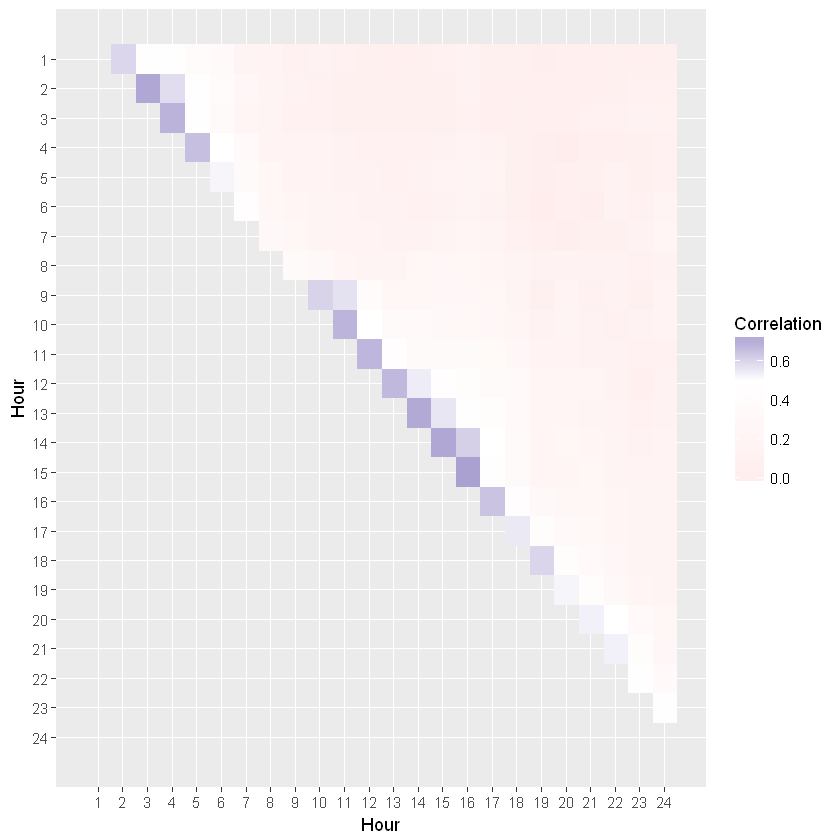

In [74]:
# Cross hour/model residual correlation, i.e. determine number of lagged variables.
fit.auto.DK1.resid.l = list()
for(hour in 1:24) {
    fit.auto.DK1.resid.l[[hour]] = resid(fit.auto.DK1[[hour]])
}
fit.auto.DK1.resid = do.call(cbind.data.frame, fit.auto.DK1.resid.l)
colnames(fit.auto.DK1.resid) = paste0("Hour ", c(1:24))
fit.auto.DK1.resid.cor = cor(fit.auto.DK1.resid)
fit.auto.DK1.resid.cor[upper.tri(fit.auto.DK1.resid.cor, diag = T)] = NA
p.fit.auto.DK1.resid.cor = fit.auto.DK1.resid.cor %>%
                              as.data.frame() %>%
                              gather() %>%
                              mutate(key = as.integer(substring(key,6)), hour = rep(c(1:24), times = 24)) %>%
                              ggplot(aes(x = hour, y = key, fill = value)) + 
                                geom_raster() +
                                labs(x = "Hour", y = "Hour", fill = "Correlation") +
                                scale_y_reverse(breaks = seq(1,24,1), minor_breaks = NULL) + 
                                scale_x_continuous(breaks = seq(1,24,1), minor_breaks = NULL) +
                                scale_fill_gradient2(low = "#ffeded", mid = "white", midpoint = 0.5, na.value = "#00000000")
p.fit.auto.DK1.resid.cor

In [92]:
# Step 6a: Re-estimate "best" model with lags
# hour:    1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
nlags = c( 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0)
fit.auto.DK1.re = list()
for(hour in 1:24) {
    Spread = df.DK1.reg[[hour]]$Spread
    xreg   = df.DK1.reg[[hour]] %>% select(one_of(df.DK1.stlrm.names[[hour]]),
                                           num_range("lag.Spread.", c(0:nlags[hour])) )
    #bm = subset(trace.auto.DK1, minAICc == T & Hour == hour) # best model
    bm = fit.auto.DK1[[hour]]$arma %>%
            t() %>%
            data.frame() %>% 
            setNames(c("p","q","P","Q","M","d","D")) %>%
            mutate( season = ifelse(P > 0 | Q > 0, 1, 0))
    fit.auto.DK1.re[[hour]] = Arima(Spread, 
                                    order = c(bm$p, bm$d, bm$q),
                                    seasonal = if(as.logical(bm$season)) c(bm$P,bm$D,bm$Q) else c(0,0,0),
                                    xreg = xreg)
}

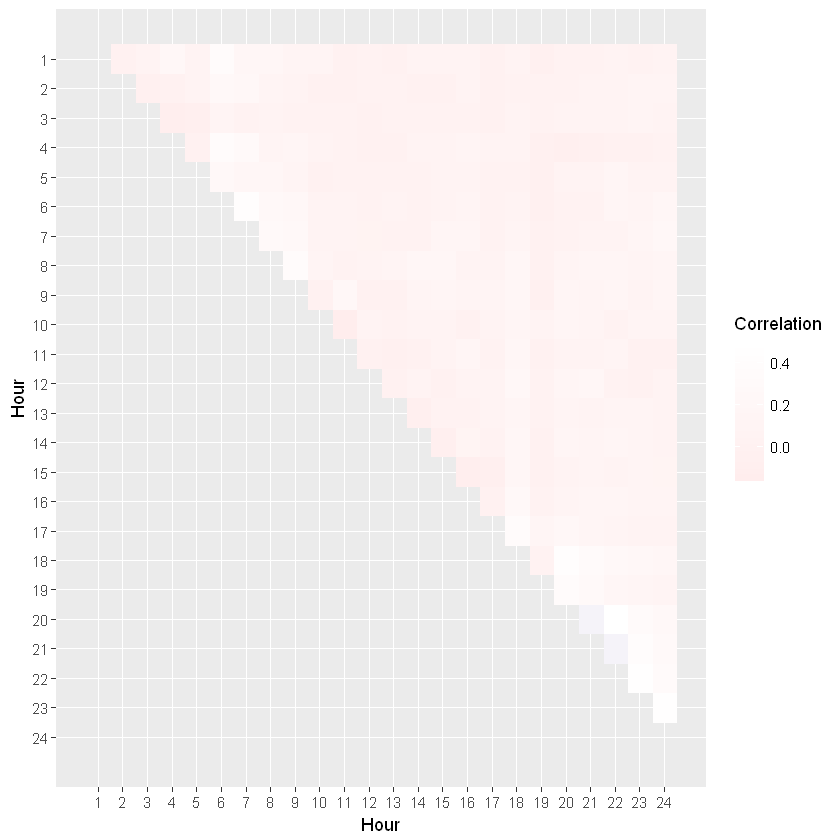

In [93]:
# Refitted model: cross hour/model residual correlation.
fit.auto.DK1.re.resid.l = list()
for(hour in 1:24) {
    fit.auto.DK1.re.resid.l[[hour]] = resid(fit.auto.DK1.re[[hour]])
}
fit.auto.DK1.re.resid = do.call(cbind.data.frame, fit.auto.DK1.re.resid.l)
colnames(fit.auto.DK1.re.resid) = paste0("Hour ", c(1:24))
fit.auto.DK1.re.resid.cor = cor(fit.auto.DK1.re.resid)
fit.auto.DK1.re.resid.cor[upper.tri(fit.auto.DK1.re.resid.cor, diag = T)] = NA
p.fit.auto.DK1.re.resid.cor = fit.auto.DK1.re.resid.cor %>%
                              as.data.frame() %>%
                              gather() %>%
                              mutate(key = as.integer(substring(key,6)), hour = rep(c(1:24), times = 24)) %>%
                              ggplot(aes(x = hour, y = key, fill = value)) + 
                                geom_raster() +
                                labs(x = "Hour", y = "Hour", fill = "Correlation") +
                                scale_y_reverse(breaks = seq(1,24,1), minor_breaks = NULL) + 
                                scale_x_continuous(breaks = seq(1,24,1), minor_breaks = NULL) +
                                scale_fill_gradient2(low = "#ffeded", mid = "white", midpoint = 0.5, na.value = "#00000000")
p.fit.auto.DK1.re.resid.cor

In [106]:
# Refitted model residual ACF and PACF
pp.fit.auto.DK1.re.acf = list()
pp.fit.auto.DK1.re.pacf = list()
for(hour in 1:24) {
    model = fit.auto.DK1.re[[hour]]
    pp.fit.auto.DK1.re.acf[[hour]] = resid(model) %>% ggAcf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8))  
    pp.fit.auto.DK1.re.pacf[[hour]] = resid(model) %>% ggPacf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8))  
}
p.fit.auto.DK1.re.acf = marrangeGrob(pp.fit.auto.DK1.re.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1 (re-fitted)")
ggsave("figures/p.fit.auto.DK1.re.acf.pdf", p.fit.auto.DK1.re.acf, width=420, height=297, units="mm")
p.fit.auto.DK1.re.pacf = marrangeGrob(pp.fit.auto.DK1.re.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1 (re-fitted)")
ggsave("figures/p.fit.auto.DK1.re.pacf.pdf", p.fit.auto.DK1.re.pacf, width=420, height=297, units="mm")

In [95]:
# Refitted model parameter estimates (well formated)
t.fit.auto.DK1.re = wellformated(fit.auto.DK1.re)
tt.fit.auto.DK1.re = cbind(
                      "Coefficient" = sub("^(\\S*\\s+).*", "\\1", rownames(t.fit.auto.DK1.re) ),
                      data.frame( round(t.fit.auto.DK1.re, digits=3), row.names=NULL)
                  ) %>% 
                  rename_at(vars(starts_with('V')), funs(sub('V','Hour ', .)))
write.csv(tt.fit.auto.DK1.re, "tables/tt.fit.auto.DK1.re.csv", row.names=F)

Warning message in sqrt(diag(li$var.coef)):
"NaNs produced"Warning message in sqrt(diag(li$var.coef)):
"NaNs produced"Warning message in sqrt(diag(li$var.coef)):
"NaNs produced"

##### 1.3.1.1.2 Manual model selection

In [191]:
# Step 4b: Manually selected model (based on ACF and PACF plots of the first-differenced time-series).
fit.manual.DK1.p = c(0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,1,0)
fit.manual.DK1.q = c(1,1,1,1,2,1,3,1,1,1,3,1,2,4,4,1,1,1,2,1,1,1,1,2)
fit.manual.DK1.P = rep(0, 24)
fit.manual.DK1.Q = rep(0, 24)
fit.manual.DK1 = list()
for(hour in 1:24) {
    Spread = df.DK1.reg[[hour]]$Spread
    xreg   = df.DK1.reg[[hour]] %>% select(one_of(df.DK1.stlrm.names[[hour]]))
    fit.manual.DK1[[hour]] = Arima(Spread, 
                                   order = c(fit.manual.DK1.p[hour], 1, fit.manual.DK1.q[hour]),
                                   seasonal = c(fit.manual.DK1.P[hour], 0, fit.manual.DK1.Q[hour]),
                                   xreg = xreg)
}

In [192]:
# Step 5b: Check model

In [193]:
# Manually selected model residual ACF and PACF
pp.fit.manual.DK1.acf = list()
pp.fit.manual.DK1.pacf = list()
for(hour in 1:24) {
    model = fit.manual.DK1[[hour]]
    pp.fit.manual.DK1.acf[[hour]] = resid(model) %>% ggAcf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8)) #+ scale_x_continuous(breaks = seq(0,35,7), minor_breaks = NULL) 
    pp.fit.manual.DK1.pacf[[hour]] = resid(model) %>% ggPacf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8)) #+ scale_x_continuous(breaks = seq(0,35,7), minor_breaks = NULL)  
}
p.fit.manual.DK1.acf = marrangeGrob(pp.fit.manual.DK1.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1 (manual)")
ggsave("figures/p.fit.manual.DK1.acf.pdf", p.fit.manual.DK1.acf, width=420, height=297, units="mm")
p.fit.manual.DK1.pacf = marrangeGrob(pp.fit.manual.DK1.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1 (manual)")
ggsave("figures/p.fit.manual.DK1.pacf.pdf", p.fit.manual.DK1.pacf, width=420, height=297, units="mm")

In [194]:
# Roots of characteristic polynomial.
p.fit.manual.DK1.roots.l = list()
for(hour in 1:24) {
    p.fit.manual.DK1.roots.l[[hour]] = autoplot(fit.manual.DK1[[hour]]) + 
                                            labs(title = sprintf("Hour %i",hour), subtitle = as.character(fit.manual.DK1[[hour]])) + 
                                            theme(plot.subtitle=element_text(size=8), plot.title=element_text(size=12), legend.position = "none")
}
p.fit.manual.DK1.roots = marrangeGrob(p.fit.manual.DK1.roots.l, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1 (manual)")
ggsave("figures/p.fit.manual.DK1.roots.pdf", p.fit.manual.DK1.roots, width=420, height=297, units="mm")

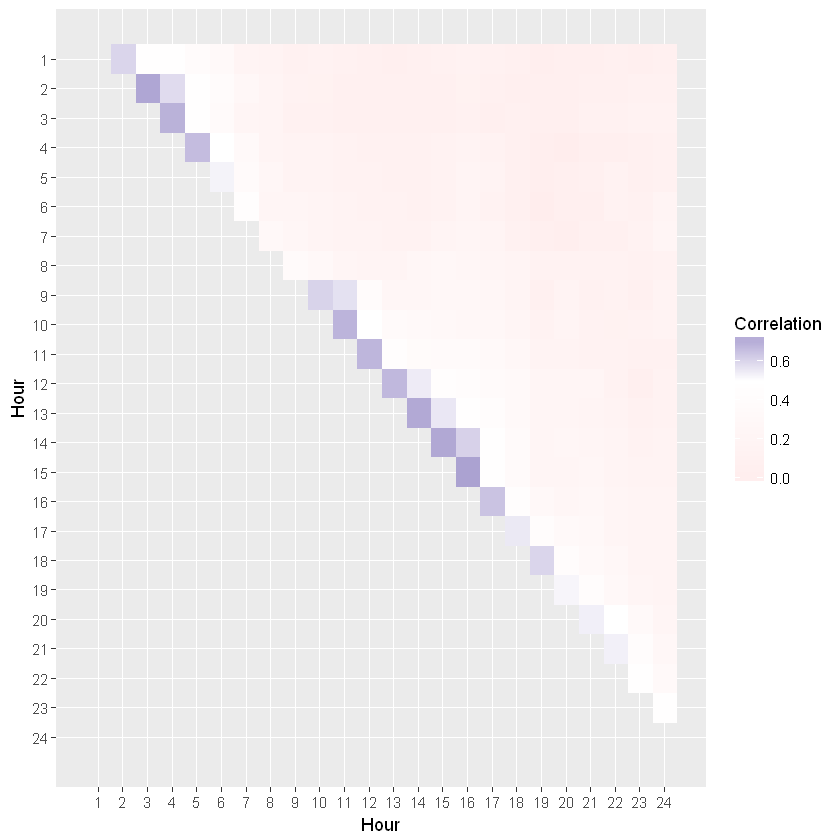

In [195]:
# Cross hour/model residual correlation, i.e. determine number of lagged variables.
fit.manual.DK1.resid.l = list()
for(hour in 1:24) {
    fit.manual.DK1.resid.l[[hour]] = resid(fit.manual.DK1[[hour]])
}
fit.manual.DK1.resid = do.call(cbind.data.frame, fit.manual.DK1.resid.l)
colnames(fit.manual.DK1.resid) = paste0("Hour ", c(1:24))
fit.manual.DK1.resid.cor = cor(fit.manual.DK1.resid)
fit.manual.DK1.resid.cor[upper.tri(fit.manual.DK1.resid.cor, diag = T)] = NA
p.fit.manual.DK1.resid.cor = fit.manual.DK1.resid.cor %>%
                              as.data.frame() %>%
                              gather() %>%
                              mutate(key = as.integer(substring(key,6)), hour = rep(c(1:24), times = 24)) %>%
                              ggplot(aes(x = hour, y = key, fill = value)) + 
                                geom_raster() +
                                labs(x = "Hour", y = "Hour", fill = "Correlation") +
                                scale_y_reverse(breaks = seq(1,24,1), minor_breaks = NULL) + 
                                scale_x_continuous(breaks = seq(1,24,1), minor_breaks = NULL) +
                                scale_fill_gradient2(low = "#ffeded", mid = "white", midpoint = 0.5, na.value = "#00000000")
p.fit.manual.DK1.resid.cor

In [196]:
# Step 6b: Re-estimate "best" model with lags
# hour:    1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
nlags = c( 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0)
fit.manual.DK1.re = list()
for(hour in 1:24) {
    Spread = df.DK1.reg[[hour]]$Spread
    xreg   = df.DK1.reg[[hour]] %>% select(one_of(df.DK1.stlrm.names[[hour]]),
                                           num_range("lag.Spread.", c(0:nlags[hour])) )
    bm = fit.manual.DK1[[hour]]$arma %>%
            t() %>%
            data.frame() %>% 
            setNames(c("p","q","P","Q","M","d","D")) %>%
            mutate( season = ifelse(P > 0 | Q > 0, 1, 0))
    fit.manual.DK1.re[[hour]] = Arima(Spread, 
                                      order = c(bm$p, bm$d, bm$q),
                                      seasonal = if(as.logical(bm$season)) c(bm$P,bm$D,bm$Q) else c(0,0,0),
                                      xreg = xreg)
}

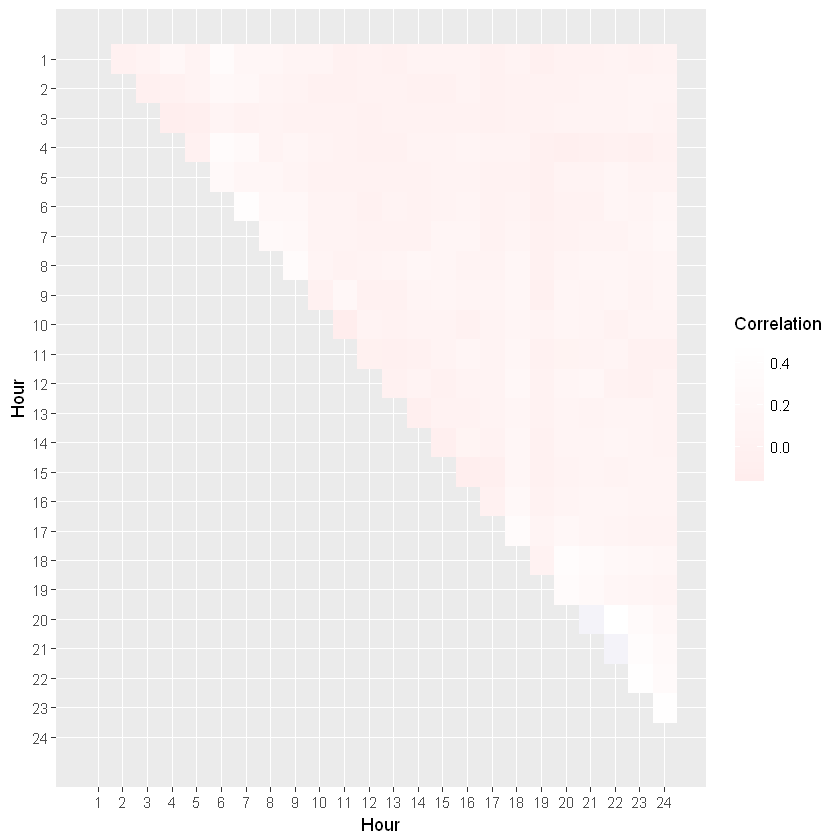

In [197]:
# Refitted model: cross hour/model residual correlation.
fit.manual.DK1.re.resid.l = list()
for(hour in 1:24) {
    fit.manual.DK1.re.resid.l[[hour]] = resid(fit.manual.DK1.re[[hour]])
}
fit.manual.DK1.re.resid = do.call(cbind.data.frame, fit.manual.DK1.re.resid.l)
colnames(fit.manual.DK1.re.resid) = paste0("Hour ", c(1:24))
fit.manual.DK1.re.resid.cor = cor(fit.manual.DK1.re.resid)
fit.manual.DK1.re.resid.cor[upper.tri(fit.manual.DK1.re.resid.cor, diag = T)] = NA
p.fit.manual.DK1.re.resid.cor = fit.manual.DK1.re.resid.cor %>%
                                  as.data.frame() %>%
                                  gather() %>%
                                  mutate(key = as.integer(substring(key,6)), hour = rep(c(1:24), times = 24)) %>%
                                  ggplot(aes(x = hour, y = key, fill = value)) + 
                                    geom_raster() +
                                    labs(x = "Hour", y = "Hour", fill = "Correlation") +
                                    scale_y_reverse(breaks = seq(1,24,1), minor_breaks = NULL) + 
                                    scale_x_continuous(breaks = seq(1,24,1), minor_breaks = NULL) +
                                    scale_fill_gradient2(low = "#ffeded", mid = "white", midpoint = 0.5, na.value = "#00000000")
p.fit.manual.DK1.re.resid.cor

In [198]:
# Refitted model residual ACF and PACF
pp.fit.manual.DK1.re.acf = list()
pp.fit.manual.DK1.re.pacf = list()
for(hour in 1:24) {
    model = fit.manual.DK1.re[[hour]]
    pp.fit.manual.DK1.re.acf[[hour]] = resid(model) %>% ggAcf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8))  
    pp.fit.manual.DK1.re.pacf[[hour]] = resid(model) %>% ggPacf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8))  
}
p.fit.manual.DK1.re.acf = marrangeGrob(pp.fit.manual.DK1.re.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1 (manual, re-fitted)")
ggsave("figures/p.fit.manual.DK1.re.acf.pdf", p.fit.manual.DK1.re.acf, width=420, height=297, units="mm")
p.fit.manual.DK1.re.pacf = marrangeGrob(pp.fit.manual.DK1.re.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "DK1 (manual, re-fitted)")
ggsave("figures/p.fit.manual.DK1.re.pacf.pdf", p.fit.manual.DK1.re.pacf, width=420, height=297, units="mm")

In [199]:
# Refitted model parameter estimates (well formated)
t.fit.manual.DK1.re = wellformated(fit.manual.DK1.re)
t.fit.manual.DK1.re = cbind(
                      "Coefficient" = sub("^(\\S*\\s+).*", "\\1", rownames(t.fit.manual.DK1.re) ),
                      data.frame( round(t.fit.manual.DK1.re, digits=3), row.names=NULL)
                  ) %>% 
                  rename_at(vars(starts_with('V')), funs(sub('V','Hour ', .)))
write.csv(t.fit.manual.DK1.re, "tables/t.fit.manual.DK1.re.csv", row.names=F)
#write.csv2(t.fit.manual.DK1.re, "tables/t.fit.manual.DK1.re.semi.csv", row.names=F)

### 1.3.2 SE2

#### 1.3.2.1 Per hour

In [77]:
# ACF and PACF per hour
pp.ts.SE2.acf = list()
pp.ts.SE2.pacf = list()
for(hour in 1:24) {
    ts = df.SE2 %>% 
            subset(hour(dt) == hour-1) %>% 
            select(Spread) %>%
            ts(frequency=7)
    pp.ts.SE2.acf[[hour]] = ts %>% ggAcf() + labs(title = sprintf("Hour %i",hour), subtitle = "Time-series")
    pp.ts.SE2.pacf[[hour]] = ts %>% ggPacf() + labs(title = sprintf("Hour %i",hour), subtitle = "Time-series")
}
p.ts.SE2.acf = marrangeGrob(pp.ts.SE2.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE2")
ggsave("figures/p.ts.SE2.acf.pdf", p.ts.SE2.acf, width=420, height=297, units="mm")
p.ts.SE2.pacf = marrangeGrob(pp.ts.SE2.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE2")
ggsave("figures/p.ts.SE2.pacf.pdf", p.ts.SE2.pacf, width=420, height=297, units="mm")

In [78]:
# Step 1: Subset and setup.
df.SE2.reg = list()
df.SE2.lrm = list()
# Lagged independent variables for later.
df.SE2$lag.Spread.1 = lag(df.SE2$Spread, k = 1)
df.SE2$lag.Spread.2 = lag(df.SE2$Spread, k = 2)
df.SE2$lag.Spread.3 = lag(df.SE2$Spread, k = 3)
for(hour in 1:24) {
    df.hour = df.SE2 %>% subset(hour(dt) == hour-1)
    # Data for regression
    df.SE2.reg[[hour]] = df.hour %>%
        mutate(
            Spread = ts(Spread, frequency=7), 
            FE.Cons.Pos  = FE.Cons * FE.Cons.Pos,
            FE.Wind.Pos  = FE.Wind * FE.Wind.Pos
        ) %>%
        bind_cols(
            d(wday1(df.hour$dt), "Wday"),
            d(month(df.hour$dt), "Month")
        ) %>% 
        select(
            # Independent variable
            Spread, 
            # Dependent variables
            starts_with("FE.Cons"), starts_with("FE.Wind"), starts_with("DA.volume."), starts_with("Wday"), starts_with("Month"), starts_with("Holiday"), starts_with("lag.Spread")
        )
    # Simple linear regression model (without any lagged terms).
    df.SE2.lrm[[hour]] = lm(Spread ~ ., 
                            data = select(
                                          df.SE2.reg[[hour]], 
                                          -starts_with("lag.Spread")
                                         )
                           )
}

In [79]:
df.SE2.test = list()
df.SE2.test.ndiffs = list()
for(hour in 1:24) {
    # Step 2: Test stationarity of dependent variables (and number of differences)
    df.SE2.test[[hour]] = df.SE2.reg[[hour]] %>% 
                    mutate(Residuals = residuals(df.SE2.lrm[[hour]])) %>%
                    select(
                        Spread,                    # Independent variable.
                        starts_with("FE"),         # Non-dummy dependent variables.
                        starts_with("DA.volume."), 
                        Residuals                  # Residuals of regressiong with all deprendent variables.
                    )
    df.SE2.test.ndiffs[[hour]] = df.SE2.test[[hour]] %>% summarise_all(ndiffs, test = "kpss") %>% mutate(Hour = hour)
}
bind_rows(df.SE2.test.ndiffs)

Spread FE.Cons FE.Cons.Pos FE.Wind FE.Wind.Pos DA.volume.buy DA.volume.sell
1  0      1       1           1       1           1             1             
2  0      1       1           1       1           1             1             
3  0      1       1           1       1           1             1             
4  0      1       1           1       1           1             1             
5  0      1       1           0       1           1             1             
6  0      1       1           0       0           1             1             
7  0      1       1           0       0           1             1             
8  0      1       1           0       1           1             1             
9  0      1       1           0       0           1             1             
10 0      1       1           0       0           1             1             
11 0      0       0           0       0           1             1             
12 0      1       0           0       0           1             1             
13 1      1       1           0       0           1             1             
14 0      1       1           0       0           1             1             
15 1      1       1           0       0           1             1             
16 0      1       1           0       0           1             1             
17 0      1       1           0       0           1             1             
18 0      1       1           0       0           1             1             
19 0      1       1           0       0           1             1             
20 0      1       1           0       1           1             1             
21 0      1       1           1       1           1             1             
22 0      1       1           1       1           1             1             
23 0      1       1           0       0           1             1             
24 0      1       1           0       0           1             1             
   Residuals Hour
1  0          1  
2  0          2  
3  0          3  
4  0          4  
5  0          5  
6  0          6  
7  0          7  
8  0          8  
9  0          9  
10 0         10  
11 0         11  
12 0         12  
13 0         13  
14 0         14  
15 0         15  
16 0         16  
17 0         17  
18 0         18  
19 0         19  
20 0         20  
21 0         21  
22 0         22  
23 0         23  
24 0         24

In [80]:
df.SE2.stlrm = list()
df.SE2.stlrm.names = list()
for(hour in 1:24) {
    # Step 3: Remove insignificant dependent variables
    df.SE2.stlrm[[hour]] = step(df.SE2.lrm[[hour]], 
                                scope= list(lower = Spread ~ FE.Cons + FE.Cons.Pos + FE.Wind + FE.Wind.Pos, 
                                            uppler = df.SE2.lrm[[hour]]),
                                direction = "both", 
                                trace = 0)
    df.SE2.stlrm.names[[hour]] = names(df.SE2.stlrm[[hour]]$coefficients)[-1] # names of coefficients in remaining model (ignoring the intercept).
}

In [81]:
#for(hour in 1:24) {
#    cat("Hour", hour, ":", df.SE2.stlrm.names[[hour]], "\n")
#}

##### 1.3.2.1.1 Manual model selection

In [119]:
# Step 4b: Manually selected model (based on ACF and PACF plots of the first-differenced time-series).
fit.manual.SE2.p = c(1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0)
fit.manual.SE2.q = c(3,1,3,1,3,2,1,0,1,1,3,3,4,3,3,2,3,2,2,3,3,2,2,2)
fit.manual.SE2.P = rep(0, 24)
fit.manual.SE2.Q = c(0,0,2,0,0,0,0,0,1,2,2,0,0,0,0,2,2,2,2,0,1,0,0,2)
fit.manual.SE2 = list()
for(hour in 1:24) {
    Spread = df.SE2.reg[[hour]]$Spread
    xreg   = df.SE2.reg[[hour]] %>% select(one_of(df.SE2.stlrm.names[[hour]]))
    fit.manual.SE2[[hour]] =  Arima(Spread, 
                                   order = c(fit.manual.SE2.p[hour], 0, fit.manual.SE2.q[hour]),
                                   seasonal = c(fit.manual.SE2.P[hour], 0, fit.manual.SE2.Q[hour]),
                                   xreg = xreg)
}

In [120]:
# Step 5b: Check model

In [121]:
# Manually selected model residual ACF and PACF
pp.fit.manual.SE2.acf = list()
pp.fit.manual.SE2.pacf = list()
for(hour in 1:24) {
    model = fit.manual.SE2[[hour]]
    pp.fit.manual.SE2.acf[[hour]] = resid(model) %>% ggAcf(lag.max = 35) + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8)) #+ scale_x_continuous(breaks = seq(0,35,7), minor_breaks = NULL) 
    pp.fit.manual.SE2.pacf[[hour]] = resid(model) %>% ggPacf(lag.max = 35) + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8)) #+ scale_x_continuous(breaks = seq(0,35,7), minor_breaks = NULL)  
}
p.fit.manual.SE2.acf = marrangeGrob(pp.fit.manual.SE2.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE2 (manual)")
ggsave("figures/p.fit.manual.SE2.acf.pdf", p.fit.manual.SE2.acf, width=420, height=297, units="mm")
p.fit.manual.SE2.pacf = marrangeGrob(pp.fit.manual.SE2.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE2 (manual)")
ggsave("figures/p.fit.manual.SE2.pacf.pdf", p.fit.manual.SE2.pacf, width=420, height=297, units="mm")

In [122]:
# Roots of characteristic polynomial.
p.fit.manual.SE2.roots.l = list()
for(hour in 1:24) {
    p.fit.manual.SE2.roots.l[[hour]] = autoplot(fit.manual.SE2[[hour]]) + 
                                            labs(title = sprintf("Hour %i",hour), subtitle = as.character(fit.manual.SE2[[hour]])) + 
                                            theme(plot.subtitle=element_text(size=8), plot.title=element_text(size=12), legend.position = "none")
}
p.fit.manual.SE2.roots = marrangeGrob(p.fit.manual.SE2.roots.l, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE2 (manual)")
ggsave("figures/p.fit.manual.SE2.roots.pdf", p.fit.manual.SE2.roots, width=420, height=297, units="mm")

In [123]:
# Cross hour/model residual correlation, i.e. determine number of lagged variables.
fit.manual.SE2.resid.l = list()
for(hour in 1:24) {
    fit.manual.SE2.resid.l[[hour]] = resid(fit.manual.SE2[[hour]])
}
fit.manual.SE2.resid = do.call(cbind.data.frame, fit.manual.SE2.resid.l)
colnames(fit.manual.SE2.resid) = paste0("Hour ", c(1:24))
fit.manual.SE2.resid.cor = cor(fit.manual.SE2.resid)
fit.manual.SE2.resid.cor[upper.tri(fit.manual.SE2.resid.cor, diag = T)] = NA
p.fit.manual.SE2.resid.cor = fit.manual.SE2.resid.cor %>%
                              as.data.frame() %>%
                              gather() %>%
                              mutate(key = as.integer(substring(key,6)), hour = rep(c(1:24), times = 24)) %>%
                              ggplot(aes(x = hour, y = key, fill = value)) + 
                                geom_raster() +
                                labs(x = "Hour", y = "Hour", fill = "Correlation") +
                                scale_y_reverse(breaks = seq(1,24,1), minor_breaks = NULL) + 
                                scale_x_continuous(breaks = seq(1,24,1), minor_breaks = NULL) +
                                scale_fill_gradient2(low = "#ffeded", mid = "white", midpoint = 0.5, na.value = "#00000000")
p.fit.manual.SE2.resid.cor

In [124]:
# Step 6b: Re-estimate "best" model with lags
# hour:    1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
nlags = c( 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
fit.manual.SE2.re = list()
for(hour in 1:24) {
    Spread = df.SE2.reg[[hour]]$Spread
    xreg   = df.SE2.reg[[hour]] %>% select(one_of(df.SE2.stlrm.names[[hour]]),
                                           num_range("lag.Spread.", c(0:nlags[hour])) )
    bm = fit.manual.SE2[[hour]]$arma %>%
            t() %>%
            data.frame() %>% 
            setNames(c("p","q","P","Q","M","d","D")) %>%
            mutate( season = ifelse(P > 0 | Q > 0, 1, 0))
    fit.manual.SE2.re[[hour]] = Arima(Spread, 
                                      order = c(bm$p, bm$d, bm$q),
                                      seasonal = if(as.logical(bm$season)) c(bm$P,bm$D,bm$Q) else c(0,0,0),
                                      xreg = xreg)
}

In [125]:
# Refitted model: cross hour/model residual correlation.
fit.manual.SE2.re.resid.l = list()
for(hour in 1:24) {
    fit.manual.SE2.re.resid.l[[hour]] = resid(fit.manual.SE2.re[[hour]])
}
fit.manual.SE2.re.resid = do.call(cbind.data.frame, fit.manual.SE2.re.resid.l)
colnames(fit.manual.SE2.re.resid) = paste0("Hour ", c(1:24))
fit.manual.SE2.re.resid.cor = cor(fit.manual.SE2.re.resid)
fit.manual.SE2.re.resid.cor[upper.tri(fit.manual.SE2.re.resid.cor, diag = T)] = NA
p.fit.manual.SE2.re.resid.cor = fit.manual.SE2.re.resid.cor %>%
                                  as.data.frame() %>%
                                  gather() %>%
                                  mutate(key = as.integer(substring(key,6)), hour = rep(c(1:24), times = 24)) %>%
                                  ggplot(aes(x = hour, y = key, fill = value)) + 
                                    geom_raster() +
                                    labs(x = "Hour", y = "Hour", fill = "Correlation") +
                                    scale_y_reverse(breaks = seq(1,24,1), minor_breaks = NULL) + 
                                    scale_x_continuous(breaks = seq(1,24,1), minor_breaks = NULL) +
                                    scale_fill_gradient2(low = "#ffeded", mid = "white", midpoint = 0.5, na.value = "#00000000")
p.fit.manual.SE2.re.resid.cor

In [126]:
# Refitted model residual ACF and PACF
pp.fit.manual.SE2.re.acf = list()
pp.fit.manual.SE2.re.pacf = list()
for(hour in 1:24) {
    model = fit.manual.SE2.re[[hour]]
    pp.fit.manual.SE2.re.acf[[hour]] = resid(model) %>% ggAcf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8))  
    pp.fit.manual.SE2.re.pacf[[hour]] = resid(model) %>% ggPacf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8))  
}
p.fit.manual.SE2.re.acf = marrangeGrob(pp.fit.manual.SE2.re.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE2 (manual, re-fitted)")
ggsave("figures/p.fit.manual.SE2.re.acf.pdf", p.fit.manual.SE2.re.acf, width=420, height=297, units="mm")
p.fit.manual.SE2.re.pacf = marrangeGrob(pp.fit.manual.SE2.re.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE2 (manual, re-fitted)")
ggsave("figures/p.fit.manual.SE2.re.pacf.pdf", p.fit.manual.SE2.re.pacf, width=420, height=297, units="mm")

In [128]:
# Refitted model parameter estimates (well formated)
t.fit.manual.SE2.re = wellformated(fit.manual.SE2.re)
t.fit.manual.SE2.re = cbind(
                      "Coefficient" = sub("^(\\S*\\s+).*", "\\1", rownames(t.fit.manual.SE2.re) ),
                      data.frame( round(t.fit.manual.SE2.re, digits=3), row.names=NULL)
                  ) %>% 
                  rename_at(vars(starts_with('V')), funs(sub('V','Hour ', .)))
write.csv(t.fit.manual.SE2.re, "tables/t.fit.manual.SE2.re.csv", row.names=F)
#write.csv2(t.fit.manual.SE2.re, "tables/t.fit.manual.SE2.re.semi.csv", row.names=F)

### 1.3.3 SE4

#### 1.3.3.1 Per hour

In [129]:
# ACF and PACF per hour
pp.ts.SE4.acf = list()
pp.ts.SE4.pacf = list()
for(hour in 1:24) {
    ts = df.SE4 %>% 
            subset(hour(dt) == hour-1) %>% 
            select(Spread) %>%
            ts(frequency=7)
    pp.ts.SE4.acf[[hour]] = ts %>% ggAcf() + labs(title = sprintf("Hour %i",hour), subtitle = "Time-series")
    pp.ts.SE4.pacf[[hour]] = ts %>% ggPacf() + labs(title = sprintf("Hour %i",hour), subtitle = "Time-series")
}
p.ts.SE4.acf = marrangeGrob(pp.ts.SE4.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE4")
ggsave("figures/p.ts.SE4.acf.pdf", p.ts.SE4.acf, width=420, height=297, units="mm")
p.ts.SE4.pacf = marrangeGrob(pp.ts.SE4.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE4")
ggsave("figures/p.ts.SE4.pacf.pdf", p.ts.SE4.pacf, width=420, height=297, units="mm")

In [130]:
# Step 1: Subset and setup.
df.SE4.reg = list()
df.SE4.lrm = list()
# Lagged independent variables for later.
df.SE4$lag.Spread.1 = lag(df.SE4$Spread, k = 1)
df.SE4$lag.Spread.2 = lag(df.SE4$Spread, k = 2)
df.SE4$lag.Spread.3 = lag(df.SE4$Spread, k = 3)
for(hour in 1:24) {
    df.hour = df.SE4 %>% subset(hour(dt) == hour-1)
    # Data for regression
    df.SE4.reg[[hour]] = df.hour %>%
        mutate(
            Spread = ts(Spread, frequency=7), 
            FE.Cons.Pos  = FE.Cons * FE.Cons.Pos,
            FE.Wind.Pos  = FE.Wind * FE.Wind.Pos
        ) %>%
        bind_cols(
            d(wday1(df.hour$dt), "Wday"),
            d(month(df.hour$dt), "Month")
        ) %>% 
        select(
            # Independent variable
            Spread, 
            # Dependent variables
            starts_with("FE.Cons"), starts_with("FE.Wind"), starts_with("DA.volume."), starts_with("Wday"), starts_with("Month"), starts_with("Holiday"), starts_with("lag.Spread")
        )
    # Simple linear regression model (without any lagged terms).
    df.SE4.lrm[[hour]] = lm(Spread ~ ., 
                            data = select(
                                          df.SE4.reg[[hour]], 
                                          -starts_with("lag.Spread")
                                         )
                           )
}

In [131]:
df.SE4.test = list()
df.SE4.test.ndiffs = list()
for(hour in 1:24) {
    # Step 2: Test stationarity of dependent variables (and number of differences)
    df.SE4.test[[hour]] = df.SE4.reg[[hour]] %>% 
                    mutate(Residuals = residuals(df.SE4.lrm[[hour]])) %>%
                    select(
                        Spread,                    # Independent variable.
                        starts_with("FE"),         # Non-dummy dependent variables.
                        starts_with("DA.volume."), 
                        Residuals                  # Residuals of regressiong with all deprendent variables.
                    )
    df.SE4.test.ndiffs[[hour]] = df.SE4.test[[hour]] %>% summarise_all(ndiffs, test = "kpss") %>% mutate(Hour = hour)
}
bind_rows(df.SE4.test.ndiffs)

Spread FE.Cons FE.Cons.Pos FE.Wind FE.Wind.Pos DA.volume.buy DA.volume.sell
1  0      0       0           0       0           1             1             
2  0      0       0           0       0           1             1             
3  0      0       0           0       0           1             1             
4  0      0       0           0       0           1             1             
5  0      0       0           0       0           1             1             
6  0      1       1           0       0           1             1             
7  0      0       0           0       0           1             1             
8  0      0       0           0       0           1             1             
9  0      1       1           0       0           1             1             
10 0      1       1           0       0           1             1             
11 0      1       1           0       0           1             1             
12 0      1       0           1       0           1             1             
13 1      0       0           1       0           1             1             
14 1      0       0           1       0           1             1             
15 1      0       0           1       0           1             1             
16 0      0       0           0       0           1             1             
17 0      0       0           0       0           1             1             
18 0      0       0           0       0           1             1             
19 0      0       0           0       0           1             1             
20 0      0       0           0       0           1             1             
21 0      0       0           0       0           1             1             
22 0      0       0           0       0           1             1             
23 0      0       0           0       0           1             1             
24 0      0       0           0       0           1             1             
   Residuals Hour
1  0          1  
2  0          2  
3  0          3  
4  0          4  
5  0          5  
6  0          6  
7  1          7  
8  0          8  
9  0          9  
10 0         10  
11 0         11  
12 0         12  
13 0         13  
14 1         14  
15 0         15  
16 0         16  
17 0         17  
18 0         18  
19 0         19  
20 0         20  
21 0         21  
22 0         22  
23 0         23  
24 0         24

In [132]:
df.SE4.stlrm = list()
df.SE4.stlrm.names = list()
for(hour in 1:24) {
    # Step 3: Remove insignificant dependent variables
    df.SE4.stlrm[[hour]] = step(df.SE4.lrm[[hour]], 
                                scope= list(lower = Spread ~ FE.Cons + FE.Cons.Pos + FE.Wind + FE.Wind.Pos, 
                                            uppler = df.SE4.lrm[[hour]]),
                                direction = "both", 
                                trace = 0)
    df.SE4.stlrm.names[[hour]] = names(df.SE4.stlrm[[hour]]$coefficients)[-1] # names of coefficients in remaining model (ignoring the intercept).
}

In [134]:
#for(hour in 1:24) {
#    cat("Hour", hour, ":", df.SE4.stlrm.names[[hour]], "\n")
#}

##### 1.3.3.1.1 Manual model selection

In [174]:
# Step 4b: Manually selected model (based on ACF and PACF plots of the first-differenced time-series).
fit.manual.SE4.p = rep(0, 24)
fit.manual.SE4.q = c(0,0,0,6,2,2,0,1,0,1,0,2,0,1,6,2,5,0,4,2,5,1,2,1)
fit.manual.SE4.P = rep(0, 24)
fit.manual.SE4.Q = c(0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,1,0,0)
fit.manual.SE4 = list()
for(hour in 1:24) {
    Spread = df.SE4.reg[[hour]]$Spread
    xreg   = df.SE4.reg[[hour]] %>% select(one_of(df.SE4.stlrm.names[[hour]]))
    fit.manual.SE4[[hour]] =  Arima(Spread, 
                                   order = c(fit.manual.SE4.p[hour], 0, fit.manual.SE4.q[hour]),
                                   seasonal = c(fit.manual.SE4.P[hour], 0, fit.manual.SE4.Q[hour]),
                                   xreg = xreg)
}

In [175]:
# Step 5b: Check model

In [176]:
# Manually selected model residual ACF and PACF
pp.fit.manual.SE4.acf = list()
pp.fit.manual.SE4.pacf = list()
for(hour in 1:24) {
    model = fit.manual.SE4[[hour]]
    pp.fit.manual.SE4.acf[[hour]] = resid(model) %>% ggAcf(lag.max = 35) + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8)) #+ scale_x_continuous(breaks = seq(0,35,7), minor_breaks = NULL) 
    pp.fit.manual.SE4.pacf[[hour]] = resid(model) %>% ggPacf(lag.max = 35) + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8)) #+ scale_x_continuous(breaks = seq(0,35,7), minor_breaks = NULL)  
}
p.fit.manual.SE4.acf = marrangeGrob(pp.fit.manual.SE4.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE4 (manual)")
ggsave("figures/p.fit.manual.SE4.acf.pdf", p.fit.manual.SE4.acf, width=420, height=297, units="mm")
p.fit.manual.SE4.pacf = marrangeGrob(pp.fit.manual.SE4.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE4 (manual)")
ggsave("figures/p.fit.manual.SE4.pacf.pdf", p.fit.manual.SE4.pacf, width=420, height=297, units="mm")

In [177]:
# Roots of characteristic polynomial.
p.fit.manual.SE4.roots.l = list()
for(hour in 1:24) {
    p.fit.manual.SE4.roots.l[[hour]] = autoplot(fit.manual.SE4[[hour]]) + 
                                            labs(title = sprintf("Hour %i",hour), subtitle = as.character(fit.manual.SE4[[hour]])) + 
                                            theme(plot.subtitle=element_text(size=8), plot.title=element_text(size=12), legend.position = "none")
}
p.fit.manual.SE4.roots = marrangeGrob(p.fit.manual.SE4.roots.l, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE4 (manual)")
ggsave("figures/p.fit.manual.SE4.roots.pdf", p.fit.manual.SE4.roots, width=420, height=297, units="mm")

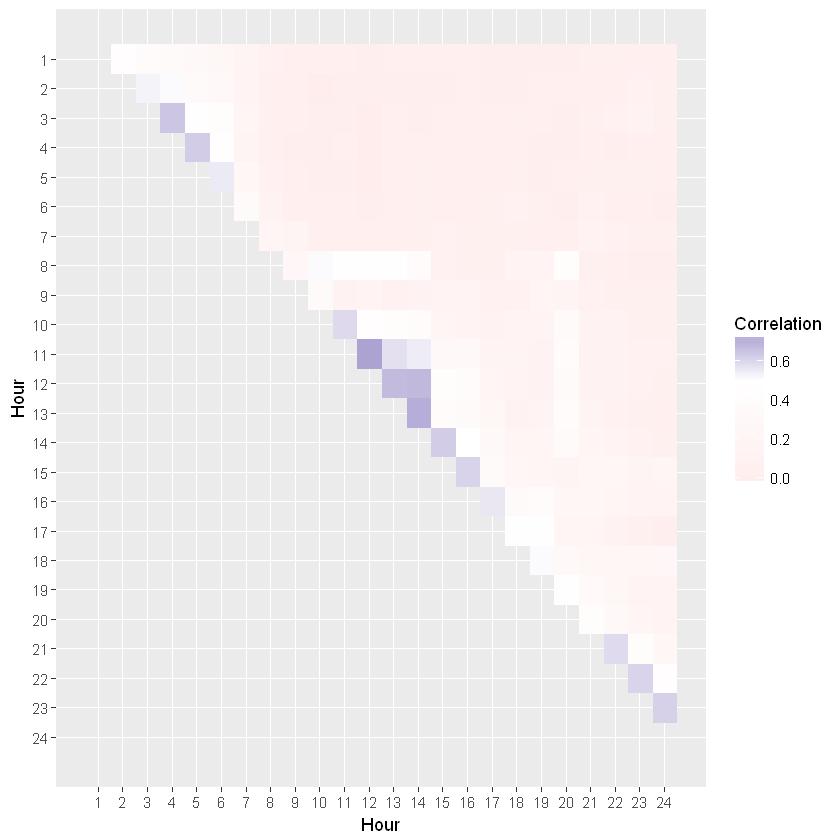

In [178]:
# Cross hour/model residual correlation, i.e. determine number of lagged variables.
fit.manual.SE4.resid.l = list()
for(hour in 1:24) {
    fit.manual.SE4.resid.l[[hour]] = resid(fit.manual.SE4[[hour]])
}
fit.manual.SE4.resid = do.call(cbind.data.frame, fit.manual.SE4.resid.l)
colnames(fit.manual.SE4.resid) = paste0("Hour ", c(1:24))
fit.manual.SE4.resid.cor = cor(fit.manual.SE4.resid)
fit.manual.SE4.resid.cor[upper.tri(fit.manual.SE4.resid.cor, diag = T)] = NA
p.fit.manual.SE4.resid.cor = fit.manual.SE4.resid.cor %>%
                              as.data.frame() %>%
                              gather() %>%
                              mutate(key = as.integer(substring(key,6)), hour = rep(c(1:24), times = 24)) %>%
                              ggplot(aes(x = hour, y = key, fill = value)) + 
                                geom_raster() +
                                labs(x = "Hour", y = "Hour", fill = "Correlation") +
                                scale_y_reverse(breaks = seq(1,24,1), minor_breaks = NULL) + 
                                scale_x_continuous(breaks = seq(1,24,1), minor_breaks = NULL) +
                                scale_fill_gradient2(low = "#ffeded", mid = "white", midpoint = 0.5, na.value = "#00000000")
p.fit.manual.SE4.resid.cor

In [179]:
# Step 6b: Re-estimate "best" model with lags
# hour:    1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
nlags = c( 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1)
fit.manual.SE4.re = list()
for(hour in 1:24) {
    Spread = df.SE4.reg[[hour]]$Spread
    xreg   = df.SE4.reg[[hour]] %>% select(one_of(df.SE4.stlrm.names[[hour]]),
                                           num_range("lag.Spread.", c(0:nlags[hour])) )
    bm = fit.manual.SE4[[hour]]$arma %>%
            t() %>%
            data.frame() %>% 
            setNames(c("p","q","P","Q","M","d","D")) %>%
            mutate( season = ifelse(P > 0 | Q > 0, 1, 0))
    fit.manual.SE4.re[[hour]] = Arima(Spread, 
                                      order = c(bm$p, bm$d, bm$q),
                                      seasonal = if(as.logical(bm$season)) c(bm$P,bm$D,bm$Q) else c(0,0,0),
                                      xreg = xreg)
}

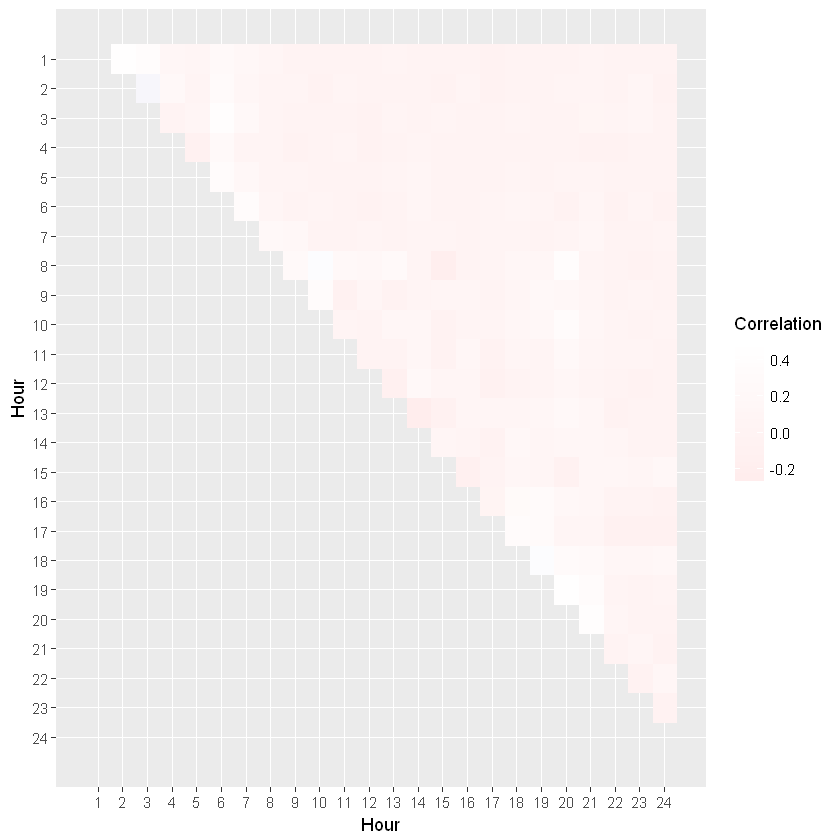

In [180]:
# Refitted model: cross hour/model residual correlation.
fit.manual.SE4.re.resid.l = list()
for(hour in 1:24) {
    fit.manual.SE4.re.resid.l[[hour]] = resid(fit.manual.SE4.re[[hour]])
}
fit.manual.SE4.re.resid = do.call(cbind.data.frame, fit.manual.SE4.re.resid.l)
colnames(fit.manual.SE4.re.resid) = paste0("Hour ", c(1:24))
fit.manual.SE4.re.resid.cor = cor(fit.manual.SE4.re.resid)
fit.manual.SE4.re.resid.cor[upper.tri(fit.manual.SE4.re.resid.cor, diag = T)] = NA
p.fit.manual.SE4.re.resid.cor = fit.manual.SE4.re.resid.cor %>%
                                  as.data.frame() %>%
                                  gather() %>%
                                  mutate(key = as.integer(substring(key,6)), hour = rep(c(1:24), times = 24)) %>%
                                  ggplot(aes(x = hour, y = key, fill = value)) + 
                                    geom_raster() +
                                    labs(x = "Hour", y = "Hour", fill = "Correlation") +
                                    scale_y_reverse(breaks = seq(1,24,1), minor_breaks = NULL) + 
                                    scale_x_continuous(breaks = seq(1,24,1), minor_breaks = NULL) +
                                    scale_fill_gradient2(low = "#ffeded", mid = "white", midpoint = 0.5, na.value = "#00000000")
p.fit.manual.SE4.re.resid.cor

In [181]:
# Refitted model residual ACF and PACF
pp.fit.manual.SE4.re.acf = list()
pp.fit.manual.SE4.re.pacf = list()
for(hour in 1:24) {
    model = fit.manual.SE4.re[[hour]]
    pp.fit.manual.SE4.re.acf[[hour]] = resid(model) %>% ggAcf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8))  
    pp.fit.manual.SE4.re.pacf[[hour]] = resid(model) %>% ggPacf() + labs(title = sprintf("Hour %i",hour), subtitle = as.character(model)) + theme(plot.subtitle=element_text(size=8))  
}
p.fit.manual.SE4.re.acf = marrangeGrob(pp.fit.manual.SE4.re.acf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE4 (manual, re-fitted)")
ggsave("figures/p.fit.manual.SE4.re.acf.pdf", p.fit.manual.SE4.re.acf, width=420, height=297, units="mm")
p.fit.manual.SE4.re.pacf = marrangeGrob(pp.fit.manual.SE4.re.pacf, nrow=4, ncol=6, layout_matrix = matrix(1:24, nrow = 4, ncol=6, byrow=T), top = "SE4 (manual, re-fitted)")
ggsave("figures/p.fit.manual.SE4.re.pacf.pdf", p.fit.manual.SE4.re.pacf, width=420, height=297, units="mm")

In [182]:
# Refitted model parameter estimates (well formated)
t.fit.manual.SE4.re = wellformated(fit.manual.SE4.re)
t.fit.manual.SE4.re = cbind(
                      "Coefficient" = sub("^(\\S*\\s+).*", "\\1", rownames(t.fit.manual.SE4.re) ),
                      data.frame( round(t.fit.manual.SE4.re, digits=3), row.names=NULL)
                  ) %>% 
                  rename_at(vars(starts_with('V')), funs(sub('V','Hour ', .)))
write.csv(t.fit.manual.SE4.re, "tables/t.fit.manual.SE4.re.csv", row.names=F)
#write.csv2(t.fit.manual.SE4.re, "tables/t.fit.manual.SE4.re.semi.csv", row.names=F)

## 1.4 Conclusion

There is no (statistically significant evidence of) asymmetry with regards to positive and negative forecast errors. Underestimating consumption (or wind power production) will result in (on average) the same sized price premium as overestimating.

The conclusion is based on the parameter estimates related to asymmetry, presented below. Note that a few parameter estimates are statistically significant at a 95% confidence interval (DK1: consumption in hour 7 and 24, wind in hour 3-4, 7 and 10. SE2: consumption in hour 1, 11 and 19. SE4: consumption in hour 9 and 24). However none of these remain statistically significant at the 99% confidence interval, and this dispite having 4 years of data for DK1 (1461 observations per hour), and just under 2 years of data for SE2 and SE4 (705 observations per hour).


In [223]:
t.fit.manual.DK1.re[c(7:8,11:12),]

Coefficient Hour 1 Hour 2 Hour 3  Hour 4 Hour 5 Hour 6 Hour 7 Hour 8 Hour 9
7  FE.Cons.Pos 13.744 -2.768 -10.770 0.054  -7.479 10.514 14.286 4.013  12.223
8  s.e.         7.040  6.878   7.338 7.229   6.726  8.046  6.580 5.365   6.673
11 FE.Wind.Pos  0.325 -1.423   2.948 4.248  -1.616  2.249  3.121 1.467  -0.345
12 s.e.         1.624  1.362   1.327 1.255   1.150  1.493  1.462 1.583   1.854
   ... Hour 15 Hour 16 Hour 17 Hour 18 Hour 19 Hour 20 Hour 21 Hour 22 Hour 23
7  ...  3.659  4.369   5.096    8.670  6.219    8.939  5.993    9.260   3.726 
8  ...  2.642  3.162   3.244    5.305  4.810    6.259  5.034    5.825   5.853 
11 ... -0.109  0.791   0.910   -1.022  0.658   -0.159  1.584   -2.203  -1.451 
12 ...  1.003  0.916   0.973    1.413  1.147    1.494  1.230    1.238   1.180 
   Hour 24
7  15.767 
8   6.056 
11  0.416 
12  1.086

In [222]:
t.fit.manual.SE2.re[c(7:8,11:12),]

Coefficient Hour 1 Hour 2 Hour 3 Hour 4 Hour 5 Hour 6 Hour 7 Hour 8 Hour 9
7  FE.Cons.Pos  5.040 -2.901 -1.626  1.512  0.639 -1.882 -3.337 -2.885 0.522 
8  s.e.         2.293  1.923  1.622  1.483  1.520  2.063  2.928  3.316 2.574 
11 FE.Wind.Pos -5.753  1.113  3.166 -0.795 -1.573  0.987 -0.067 -2.348 0.702 
12 s.e.         3.246  2.635  2.291  2.090  2.079  2.840  4.351  5.784 3.692 
   ... Hour 15 Hour 16 Hour 17 Hour 18 Hour 19 Hour 20 Hour 21 Hour 22 Hour 23
7  ... -2.335   1.000  -0.361  2.715   -6.719   0.687   1.883  -1.129   0.350 
8  ...  1.628   2.713   3.658  3.390    2.647   2.286   2.055   1.514   1.358 
11 ... -0.713  -2.060  -2.689  1.810    2.988  -0.757  -2.407   2.558  -3.865 
12 ...  2.834   4.203   5.089  4.991    4.015   3.368   2.889   2.336   2.181 
   Hour 24
7  -1.056 
8   1.598 
11 -2.072 
12  2.404

In [221]:
t.fit.manual.SE4.re[c(7:8,11:12),]

Coefficient Hour 1 Hour 2 Hour 3 Hour 4 Hour 5 Hour 6 Hour 7 Hour 8 Hour 9
7  FE.Cons.Pos  3.478 2.318  2.038  -0.602 2.020   1.501  1.569 -0.811 -7.144
8  s.e.         1.855 1.735  1.644   1.376 1.336   1.557  1.749  3.235  3.405
11 FE.Wind.Pos -3.288 1.886  1.545   1.535 1.301  -1.828 -1.524  4.173  1.206
12 s.e.         2.755 2.614  2.696   2.208 2.316   2.678  3.357  6.490  7.750
   ... Hour 15 Hour 16 Hour 17 Hour 18 Hour 19 Hour 20 Hour 21 Hour 22 Hour 23
7  ...  0.475  -0.185   3.679   7.422  6.764    2.776   0.806  -2.600  -1.049 
8  ...  2.743   2.564   3.486   3.847  4.220    4.118   3.172   2.147   2.122 
11 ... -4.586  -8.455  -6.526  -5.060  6.302   -5.022  -0.141  -6.163   2.244 
12 ...  5.408   5.250   6.809   7.820  8.303    7.557   5.317   3.746   3.304 
   Hour 24
7  -6.467 
8   2.450 
11  3.616 
12  3.441